In [1]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(dplyr, warn.conflicts = FALSE)

source("src/database/startup.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/database/query/metadata.R")
source("src/database/plot.R")
source("src/merging/analysis.R")
source("src/merging/display.R")

conns <- load_dbs()



Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [4]:
query_checkpoint_meta("ARPAE", "qc1", conns$data) |> select(ends_with("id"), name, user_code)

[1] "sensor_key"    "sensor_id"     "station_key"   "sensor_first" 
 [5] "sensor_last"   "station_id"    "name"          "network"      
 [9] "town"          "province_full" "province_code" "state"        
[13] "station_first" "station_last"  "user_code"     "series_key"   
[17] "kind"          "lon"           "lat"           "elevation"    
[21] "series_id"     "dataset"       "series_first"  "series_last"

In [2]:
query_checkpoint_meta("SCIA", "qc1", conns$data) |>
    filter(state == "Emilia-Romagna", !is.na(user_code)) |>
    collect() |>
    select(user_code, name, lon, lat) |>
    group_by(user_code) |>
    filter(n() > 1) |>
    arrange(user_code)


user_code,name,lon,lat
<chr>,<chr>,<dbl>,<dbl>
08ALBARETO,ALBARETO,9.69845,44.44688
08ALBARETO,ALBARETOAGRO,10.95149,44.58726
08BOLOGNAU,BOLOGNAUFFID,11.34614,44.49990
08BOLOGNAU,BOLOGNAURB,11.33920,44.48741
08BRISIGHE,BRISIGHELLA,11.77549,44.22289
08BRISIGHE,BRISIGHELLAAGRO,11.75186,44.21658
08CARPINET,CARPINETI,10.49533,44.46790
08CARPINET,CARPINETIAGRO,10.50390,44.47007
08CARPINET,Carpineta Rubicone,12.27260,44.08940


In [27]:
station_matches <- query_state_matches(conns$stations, "Emilia-Romagna", 10000, 500) |>
    filter(if_all(starts_with("network"), ~ . != "DPC"), dataset_y != "ARPAE") |>
    select(id_x, id_y, distance) |>
    collect()
metadata <- query_duck_metadata(conns$data)
data <- valid_data(conns$data) |> filter(between(date, as.Date("2006-01-01"), as.Date("2016-01-01")))
matches <- series_matches(data, station_matches, metadata)


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


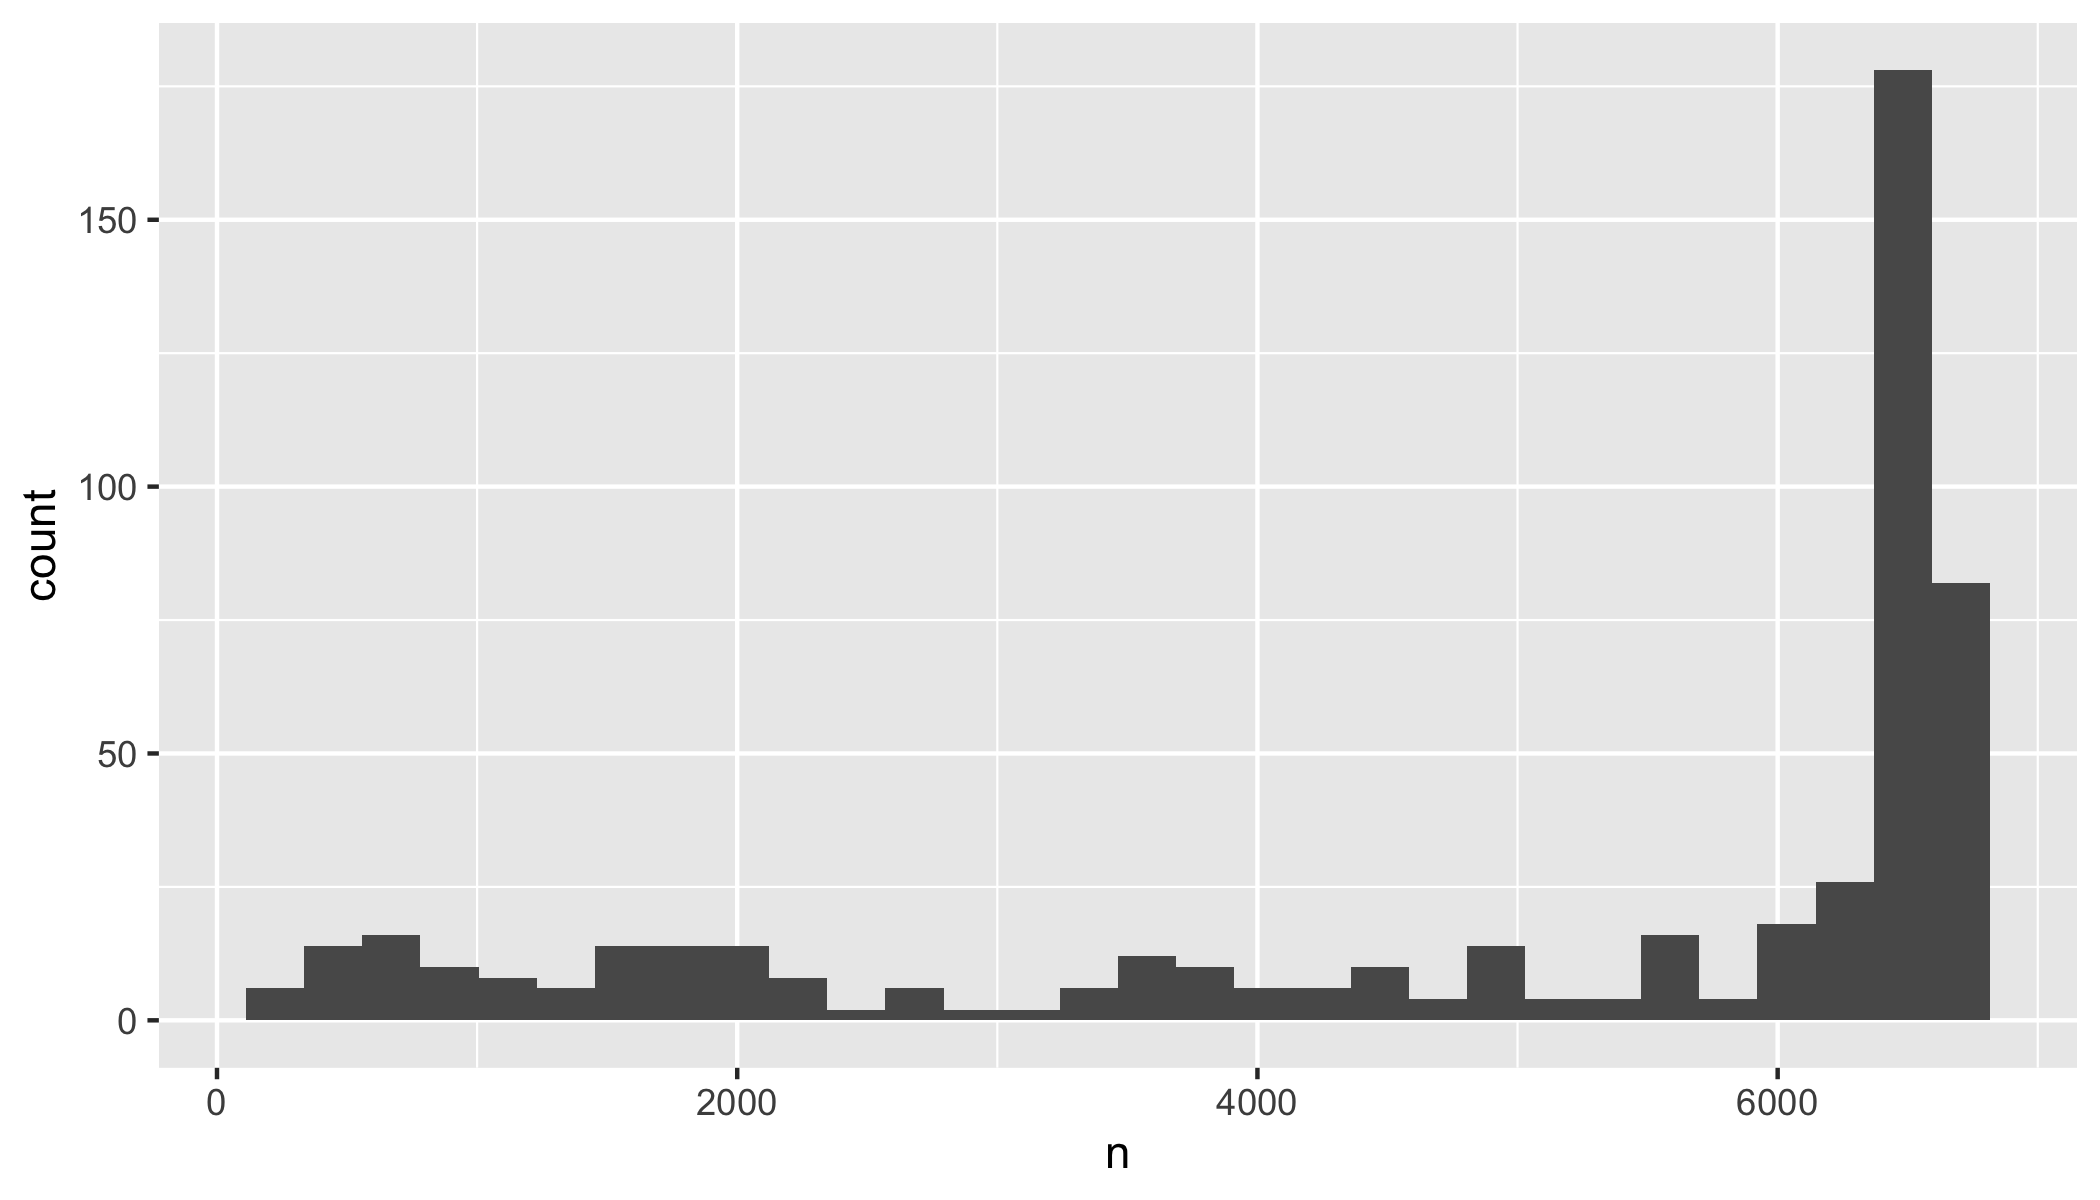

In [22]:
data |>
    filter(dataset == "ARPAE") |>
    group_by(station_id, variable) |>
    count() |>
    ggplot() +
    geom_histogram(aes(x = n))


In [26]:
metadata |>
    filter(original_dataset == "ARPAE") |>
    group_by(name) |>
    filter(n() > 1L) |>
    select(name, network, first_registration, last_registration)


# Source:   SQL [7 x 4]
# Database: DuckDB v0.9.2 [root@Darwin 23.2.0:R 4.3.2/:memory:]
# Groups:   name
  name        network first_registration last_registration
  <chr>       <chr>   <date>             <date>           
1 Carpineti   simnpr  2005-12-31         2010-03-03       
2 Carpineti   agrmet  2005-12-31         2024-01-19       
3 Villa Ghigi simnbo  2022-11-05         2024-01-19       
4 Villa Ghigi claster 2018-09-30         2019-02-19       
5 Corniolo    spdsra  2005-12-31         2024-01-19       
6 Corniolo    spdsra  2012-04-18         2024-01-19       
7 Corniolo    claster 2018-02-27         2024-01-19       

In [28]:
analysis <- series_matches_analysis(matches, data, metadata |> rename(dataset = original_dataset))


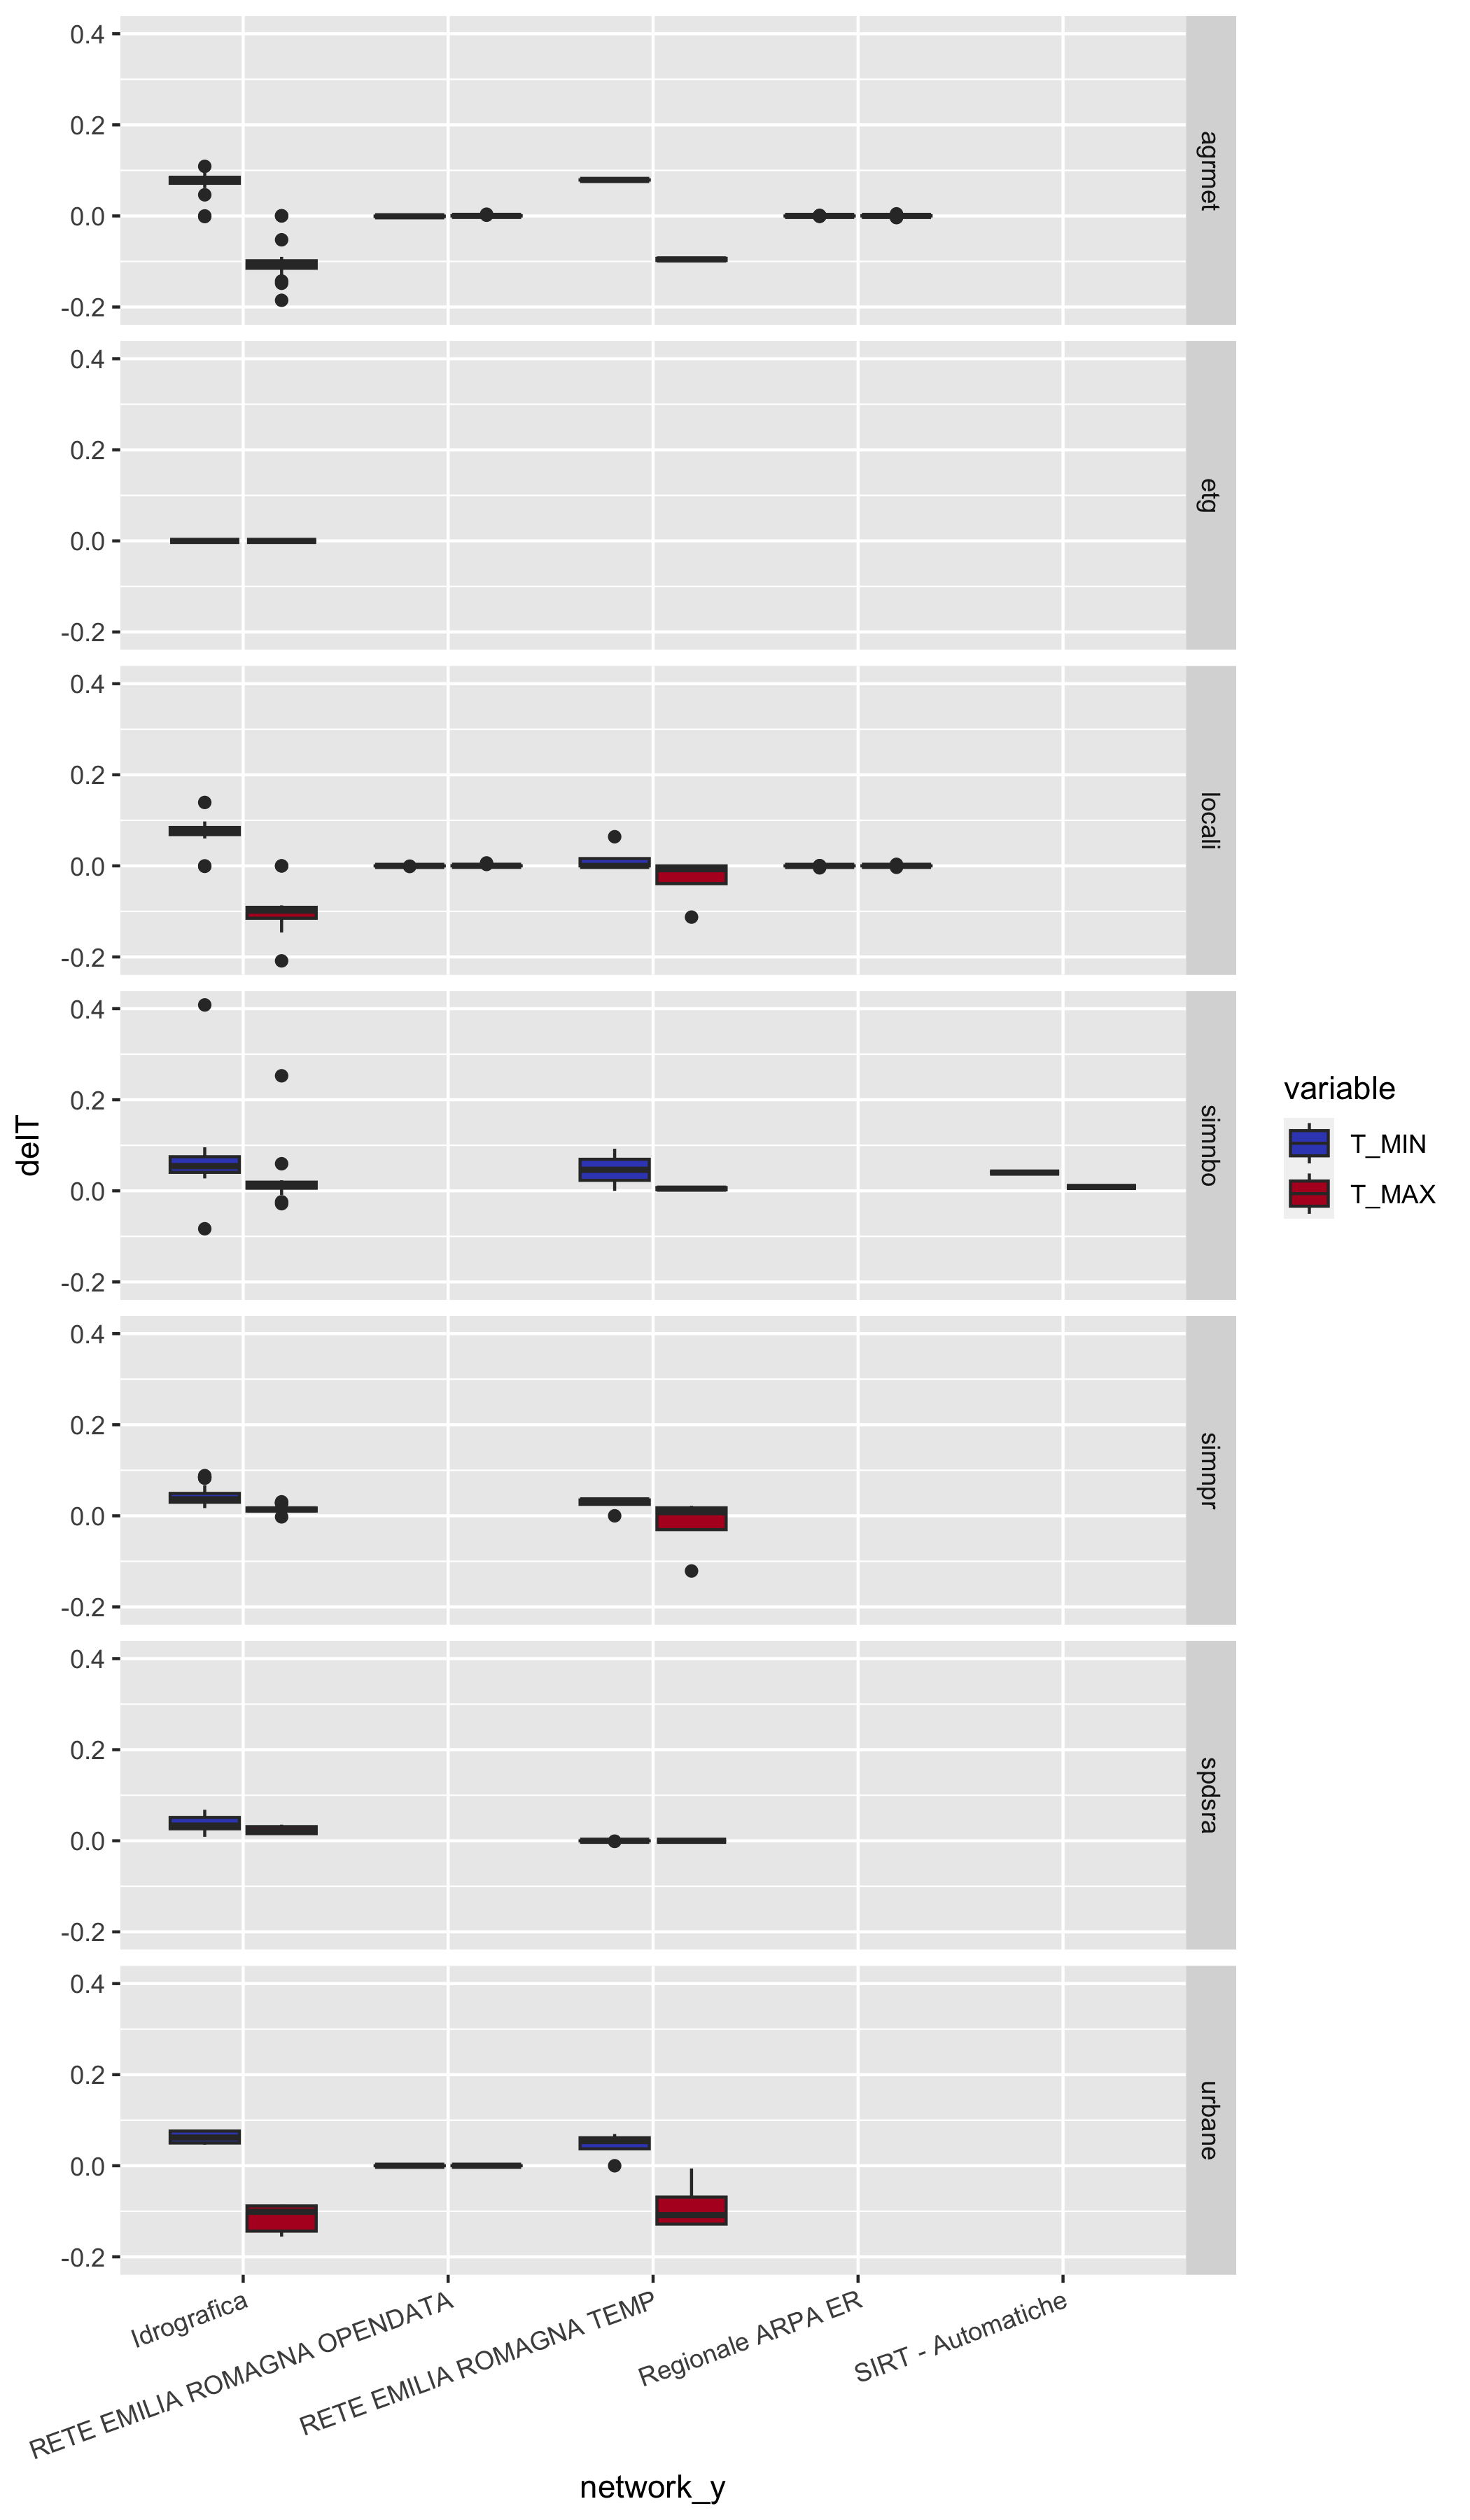

In [29]:
options(repr.plot.height = 12, repr.plot.res = 300)
library(ggplot2)
library(pals)
ggplot(data = analysis |> filter(f0 > 0.4, dataset_x == "ARPAE") |> mutate(variable = factor(variable, levels = c(-1L, 1L), labels = c("T_MIN", "T_MAX"), ordered = TRUE))) +
    geom_boxplot(aes(x = network_y, y = delT, fill = variable)) +
    scale_fill_manual(values = coolwarm(2)) +
    theme(axis.text.x = element_text(angle = 20, hjust = 1)) +
    facet_grid(network_x ~ .)


In [30]:
write_xlsx_analysis(analysis, file.path("notebooks", "integrazioni_regionali", "emilia-romagna", "merging_analysis_2006.xlsx"))


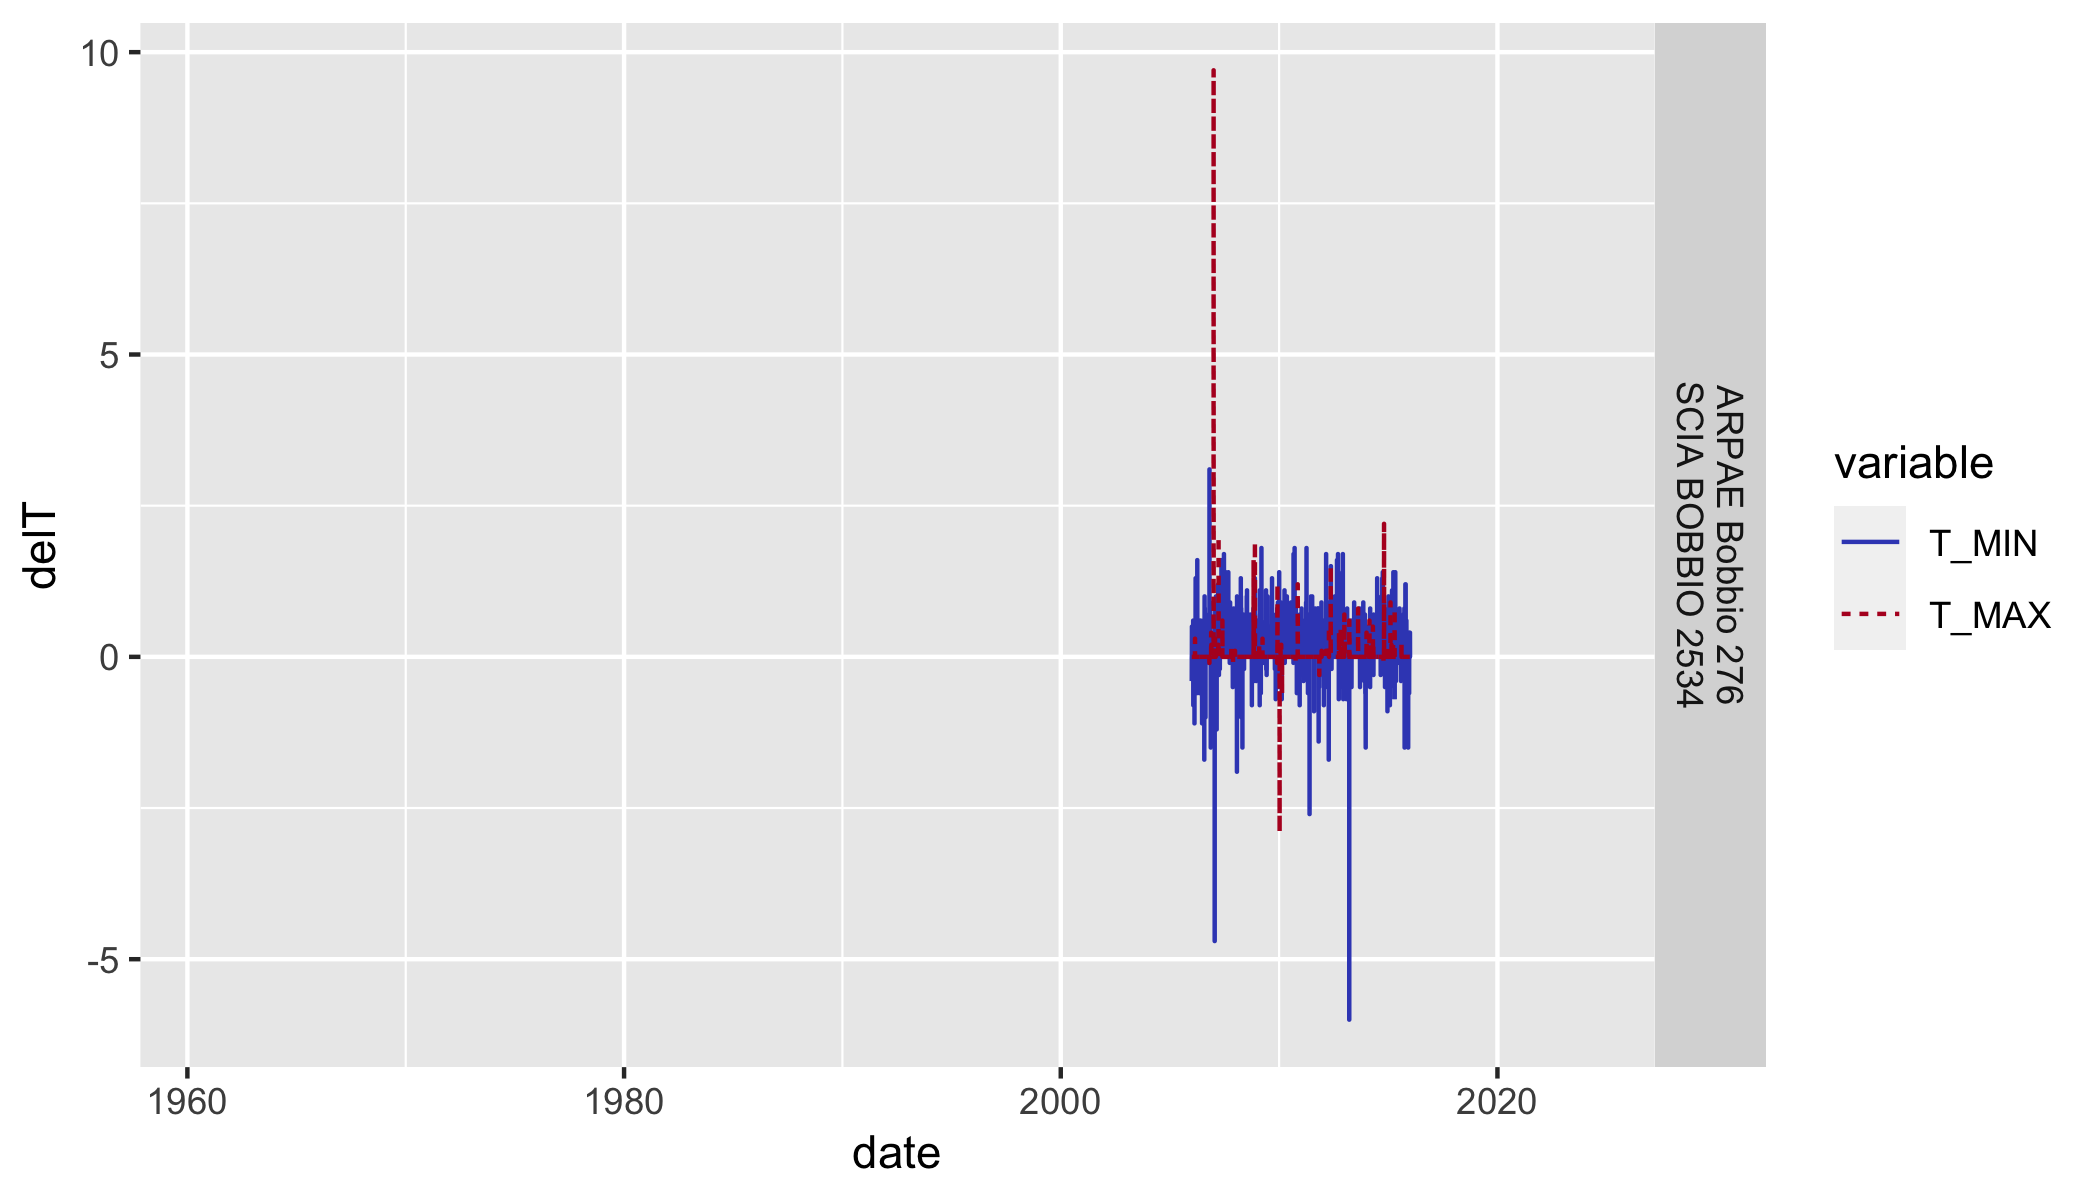

In [19]:
options(repr.plot.height = 4, repr.plot.res = 300)
plot_diffs(analysis |> filter(id_x == 276L, id_y == 2534L), conns$data)
